In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff


import warnings
warnings.filterwarnings('ignore')

import pickle

In [3]:
train = pd.read_excel('./input/ativo.xlsx')
train1 = pd.read_excel('./input/inativo.xlsx')

train = train.drop(['Associação Atlética Banco do Brasil - Sao Luis/MA', 'Unnamed: 6','Unnamed: 7', '25/11/2020 16:53:09'], axis=1)
train1 = train1.drop(['Associação Atlética Banco do Brasil - Sao Luis/MA', 'Unnamed: 6','Unnamed: 7', '25/11/2020 16:53:42'], axis=1)

train.columns = ['Nome', 'Data Nascimento', 'Telefone', 'Endereço', 'E-mail']
train1.columns = ['Nome', 'Data Nascimento', 'Telefone', 'Endereço', 'E-mail']

train = train.drop(train.index[[0,1,2,3]])
train1 = train1.drop(train1.index[[0,1,2,3]])

train['Situacao'] = 'Ativo'
train1['Situacao'] = 'Inativo'
data = pd.concat([train, train1])

In [9]:
sexo_masc = pd.read_excel('./input/homem.xlsx')
sexo_fem = pd.read_excel('./input/mulher.xlsx')

sexo_masc = sexo_masc.drop(['Associação Atlética Banco do Brasil - Sao Luis/MA', 'Unnamed: 6','Unnamed: 7', '25/11/2020 16:54:02'], axis=1)
sexo_fem = sexo_fem.drop(['Associação Atlética Banco do Brasil - Sao Luis/MA', 'Unnamed: 6', 'Unnamed: 7', '25/11/2020 16:54:30'], axis=1)

sexo_masc = sexo_masc.drop(sexo_masc.index[[0,1,2,3]])
sexo_fem = sexo_fem.drop(sexo_fem.index[[0,1,2,3]])

sexo_masc.columns = ['Nome', 'Data Nascimento', 'Telefone', 'Endereço', 'E-mail']
sexo_fem.columns = ['Nome', 'Data Nascimento', 'Telefone', 'Endereço', 'E-mail']

In [14]:
data['Sexo'] = 0
def get_sexo(text):
    for i in sexo_masc['Nome']:
        if text == i:
            text = 'M'
    for a in sexo_fem['Nome']:
        if text == a:
            text = 'F'
    return text

data['Sexo'] = data['Nome'].apply(lambda x: get_sexo(x))

In [15]:
with open('./input/matricula.pickle', 'rb') as f:
    matricula = pickle.load(f)

with open('./input/nomes.pickle', 'rb') as f:
    nomes = pickle.load(f)
    
# Create the pandas DataFrame  
df_nomes = pd.DataFrame(nomes, columns = ['Nome', 'Dependente', 'Modalidade', 'Turma', 'Plano'])
df_matricula = pd.DataFrame(matricula, columns = ['Matricula'])

df_nomes.reset_index(drop=True, inplace=True)
df_matricula.reset_index(drop=True, inplace=True)

df_nomes['Matricula'] = df_matricula['Matricula']

df = df_nomes.drop(['Turma', 'Plano'], axis=1)

In [18]:
import re
def clean_text(text):
    text = re.sub(r'[^A-Za-z _]','',text, re.UNICODE)
    text = text.rstrip()
    if text == 'NATAO':
        text = 'NATAÇÃO'
    #text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    #text = [lemmatizer.lemmatize(token, "v") for token in text]
    #text = [word for word in text if not word in stop_words]
    #text = " ".join(text)
    return text
df['Modalidade'] = df['Modalidade'].apply(lambda x: clean_text(x))
df['Nome_novo'] = df['Nome'].apply(lambda x: clean_text(x))

In [19]:
data['Esporte'] = 0
def get_esporte(text):
    for i in df['Nome_novo']:
        if i == text:
            text = df[df['Nome_novo']==i].Modalidade.values[0]
    if text not in df['Modalidade'].values:
        text = 'Não pratica'
    return text

data['Esporte'] = data['Nome'].apply(lambda x: get_esporte(x))

data['Endereço'] = data['Endereço'].fillna('Não especificado')

In [47]:
def clean_endereco(text):
    x = text.split(',')
    item = x[-1]
    elemento = item.split('-')
    elemento = elemento[0]
    elemento = elemento.strip()
    if elemento == 'RENASCEN€A' or elemento=='RENASCENÇA':
        elemento = 'RENASCENCA'
    elif elemento == 'JD.RENASCENCA' or elemento=='JD.RENASCEN€A' or elemento=='JARDIM RENASCEN€A' or elemento== 'JARDIM RENASCENÇA' or elemento == 'JARDIM RENACENCA' or elemento == 'JD RENASCENCA':
        elemento = 'JARDIM RENASCENCA'
    elif elemento == 'PONTA DAREIA' or elemento == "PONTA D'AREIA" or elemento == 'PONTA D AREIA':
        elemento = 'PONTA DA AREIA'
    elif elemento == 'RENASCENÇA II' or elemento =='RENASCEN€A II' or elemento == 'RENASCENCA 2':
        elemento = 'RENASCENCA II'
    elif elemento == 'OLHO D AGUA':
        elemento = 'OLHO DAGUA'
    text = elemento   
    return text
data['Endereço_novo'] = data['Endereço'].apply(lambda x: clean_endereco(x))
data = data.drop([3493, 1773, 1774], 0)
data.insert(0, 'id', range(0, 0 + len(data)))

In [22]:
pd.set_option('display.max_colwidth', -1)
data[data['Endereço_novo']=='BRAGA'].Endereço

908    R PERNAMBUCO 873 LOT CHACARA, 0, BRAGA-TURU - Sao Luis/MA - 65067-360
Name: Endereço, dtype: object

In [24]:
from datetime import datetime, date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


def get_idade(text):
    try:
        idade = text.split('/')
        idade = ' '.join(idade)
        idade = datetime.strptime(idade, "%d %m %Y")
        text = calculate_age(idade)
        if text > 100:
            text = 50
        elif text == np.nan:
            text = 50
    except:
        pass
    return text

data['Idade'] = data['Data Nascimento'].apply(lambda x: get_idade(x))

In [25]:
time = pd.DataFrame()
from tqdm import tqdm
import os
time_completo = pd.DataFrame(columns=['Nome', 'Time', 'Liga'])
for elemento in tqdm(os.listdir('./input/times')):
    '''ab = elemento.split('(')
    aba = ab[1].split(')')
    print(aba[0])'''
    time = time.iloc[0:0]
    time = pd.read_excel(f'./input/times/{elemento}')
    time = time.drop(['Associação Atlética Banco do Brasil - Sao Luis/MA', 'Unnamed: 6','Unnamed: 7'], axis=1)
    time.columns = ['Nome', 'Data Nascimento', 'Telefone', 'Endereço', 'E-mail','tanto faz']
    time = time.drop(['tanto faz', 'Telefone', 'Endereço', 'E-mail', 'Data Nascimento'], axis=1)
    time = time.drop(time.index[[0,1,2,3]])
    nome_time = elemento.split('(')
    nome_time = nome_time[0]
    time['Time'] = nome_time
    nome_liga = elemento.split('(')
    nome_liga = nome_liga[1].split(')')
    nome_liga = nome_liga[0]
    time['Liga'] = nome_liga
    time_completo = time_completo.append(time)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 24.86it/s]


In [26]:
data['Time'] = 'Não participa'
data['Liga'] = 'Não participa'
#time_completo = time_completo.reset_index()
def get_camp(text):
    for i in time_completo['Nome']:
        if i == text:
            text = time_completo[time_completo['Nome']==i].Time.values[0]
    if text not in time_completo['Time'].values:
        text = 'Não Participa'
    return text

def get_liga(text):
    for i in time_completo['Nome']:
        if i == text:
            text = time_completo[time_completo['Nome']==i].Liga.values[0]
    if text not in time_completo['Liga'].values:
        text = 'Não Participa'
    return text

data['Time'] = data['Nome'].apply(lambda x: get_camp(x))
data['Liga'] = data['Nome'].apply(lambda x: get_liga(x))

# Visualização por sexo

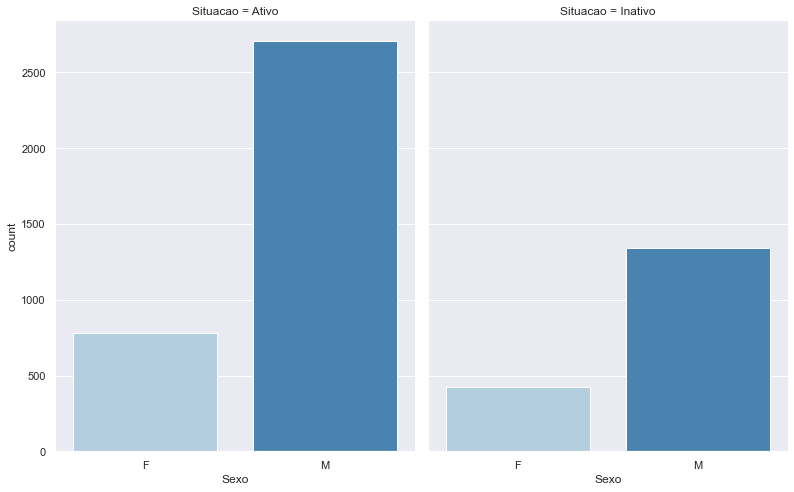

In [27]:
data_v =data.groupby(['Sexo','Situacao'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Sexo", y="count",col="Situacao",
                data=data_v, kind="bar",
                height=7, aspect=0.8, palette='Blues');

# Visualizações por bairro

Text(0.5, 1.0, 'Visualização de clientes por Bairro')

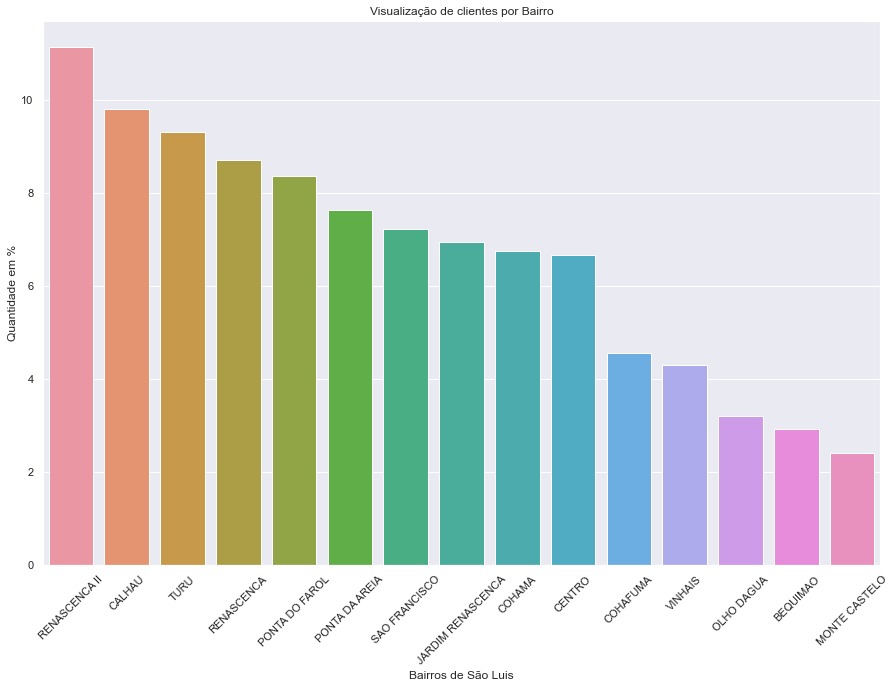

In [28]:
data_v = data['Endereço_novo'].value_counts()
data_v_50 = data_v[data_v>50]
total = data_v[data_v>50]
total = total.values.sum()
numero_de_bairros = data_v_50.sort_values(ascending=False)

#Visualização
plt.figure(figsize=(15,10))
sns.barplot(x=numero_de_bairros.index, y=numero_de_bairros.values/total*100)
plt.xticks(rotation= 45)
plt.xlabel('Bairros de São Luis')
plt.ylabel('Quantidade em %')
plt.title('Visualização de clientes por Bairro')

## Bairros com maior percentual de associados ativos

Text(0.5, 1.0, 'Percentual de clientes ativos por Bairro')

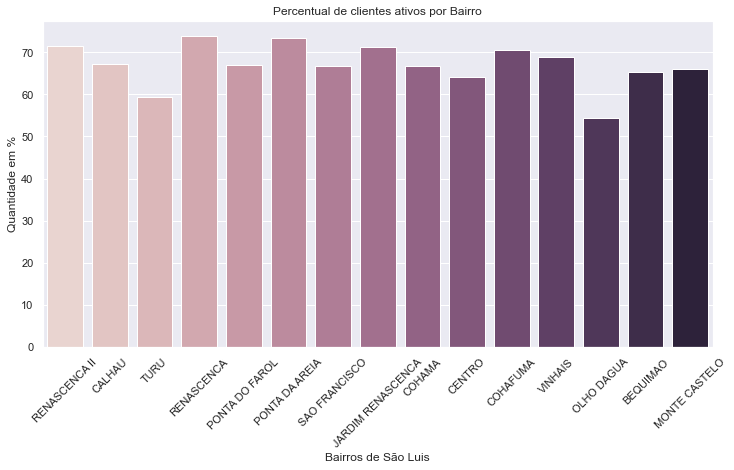

In [29]:
aaa = data['Endereço_novo'].value_counts().sort_values(ascending=False)
lista_bairros_50 = aaa[aaa>50].index
lista_controle = []
for i in lista_bairros_50:
    novo_data = data[data['Endereço_novo']==i]
    resultado = novo_data.Situacao.value_counts().values
    resultado = (resultado[0]/(resultado[0]+resultado[1]))*100
    lista_controle.append(resultado)

#Visualização
plt.figure(figsize=(12,6))
sns.barplot(x=lista_bairros_50, y=lista_controle, palette = sns.cubehelix_palette(len(lista_bairros_50)))
plt.xticks(rotation= 45)
plt.xlabel('Bairros de São Luis')
plt.ylabel('Quantidade em %')
plt.title('Percentual de clientes ativos por Bairro')

## Bairros com menor percentual de associados ativos

Text(0.5, 1.0, 'Percentual de clientes inativos por Bairro (Com quantidade acima de 35 associados)')

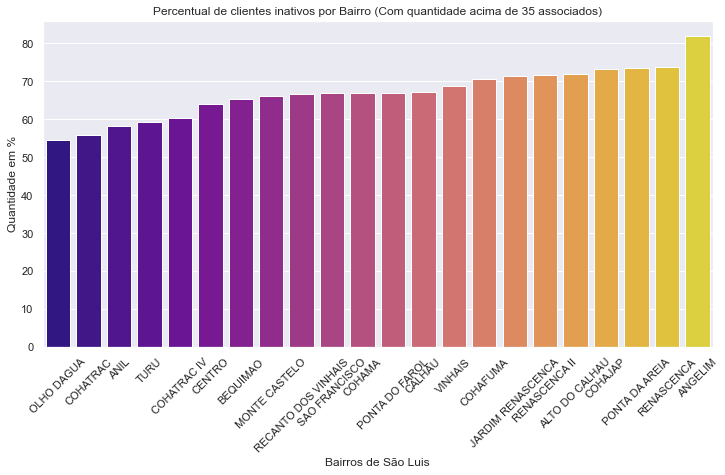

In [30]:
aaa = data['Endereço_novo'].value_counts().sort_values(ascending=False)
lista_bairros_50 = aaa[aaa>35].index
lista = []
lista_controle = []
for i in lista_bairros_50:
    novo_data = data[data['Endereço_novo']==i]
    resultado = novo_data.Situacao.value_counts().values
    resultado = (resultado[0]/(resultado[0]+resultado[1]))*100
    lista_controle.append(resultado)
    lista_controle.append(i)
    lista.append(lista_controle)
    lista_controle = []
nova_data = pd.DataFrame(lista, columns = ['Quantidade', 'Bairro'])
nova_data = nova_data.sort_values(ascending= True, by='Quantidade')


#Visualização
plt.figure(figsize=(12,6))
sns.barplot(x=nova_data.Bairro, y=nova_data.Quantidade, palette = 'plasma')
plt.xticks(rotation= 45)
plt.xlabel('Bairros de São Luis')
plt.ylabel('Quantidade em %')
plt.title('Percentual de clientes inativos por Bairro (Com quantidade acima de 35 associados)')

# Visualizações por esporte (escolinha)

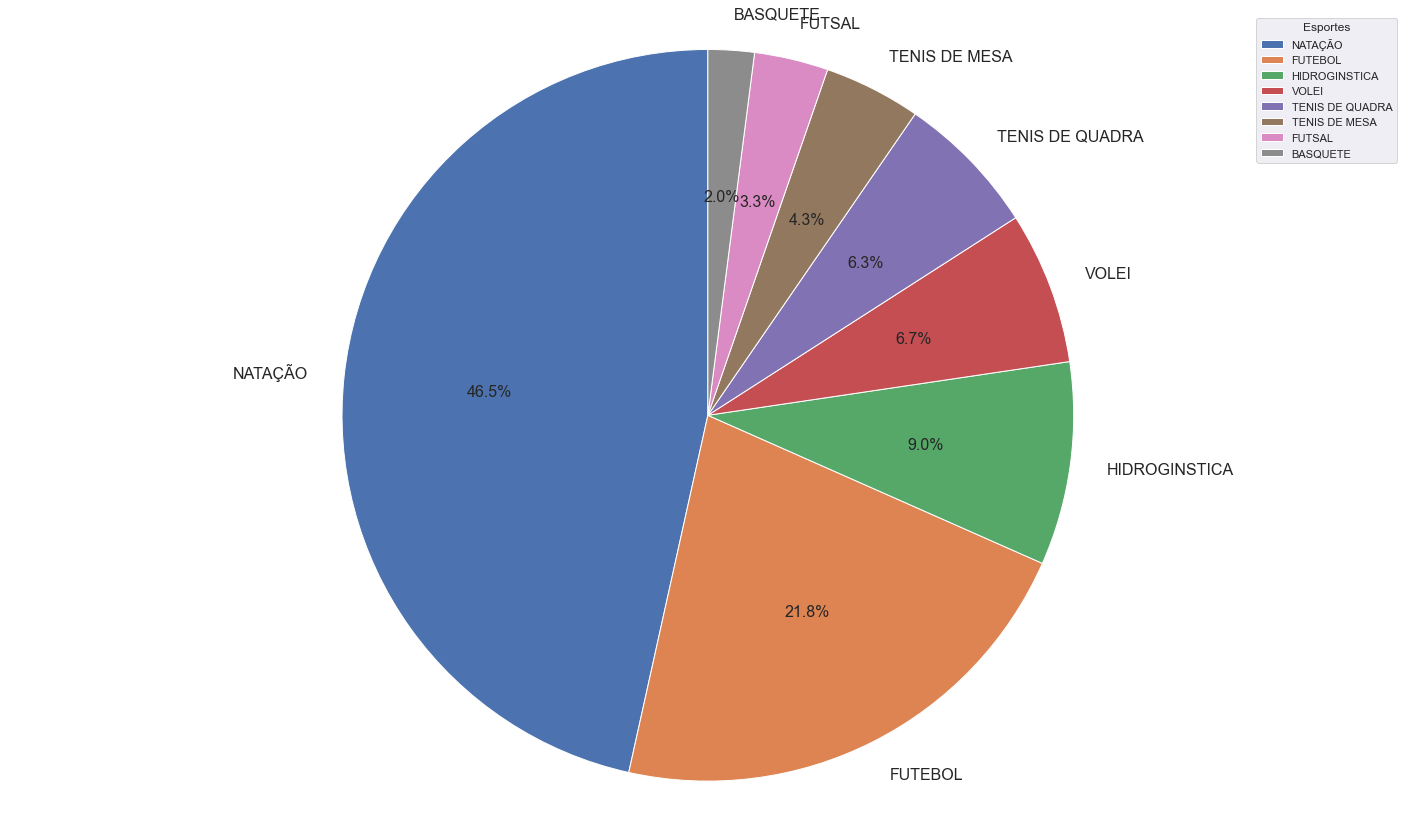

In [31]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.Modalidade.value_counts().index
sizes = df.Modalidade.value_counts().values
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,radius=0.5, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(title='Esportes')
plt.show()

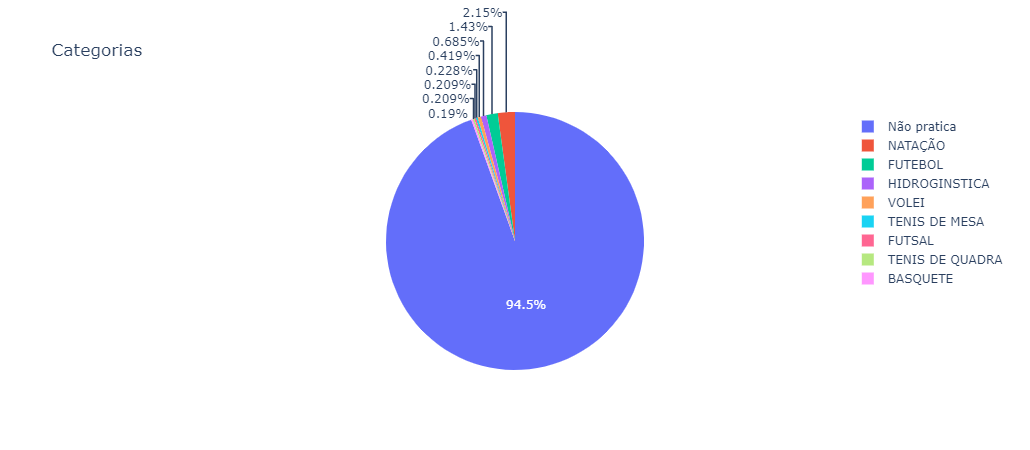

In [32]:
import plotly.express as px
df2 = data['Esporte'].value_counts()
fig = px.pie(df2, values=df2.values, names=df2.index, title='Categorias')
fig.show()

Text(0, 0.5, 'Quantidade')

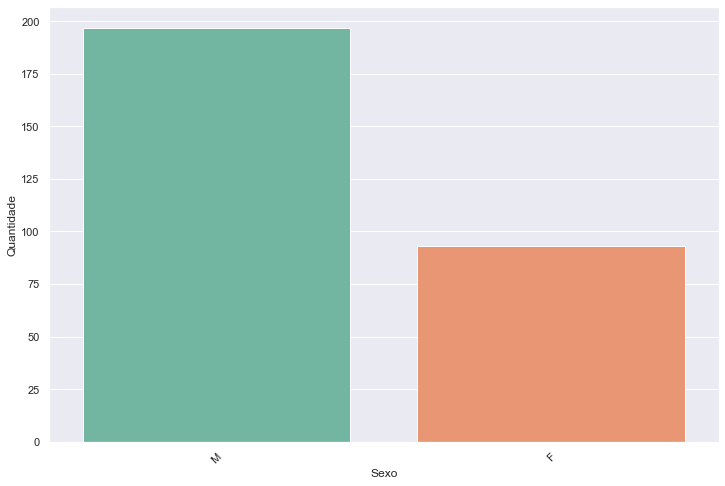

In [33]:
data_prov = data[data['Esporte'] != 'Não pratica']

data_prov = data_prov['Sexo'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(12,8))
sns.barplot(x=data_prov.index, y=data_prov.values, palette=sns.color_palette("Set2"))
plt.xticks(rotation=45)
plt.xlabel('Sexo')
plt.ylabel('Quantidade')

# Visualizações Idade

Text(0.5, 1.0, 'Quantidade de associados por idade')

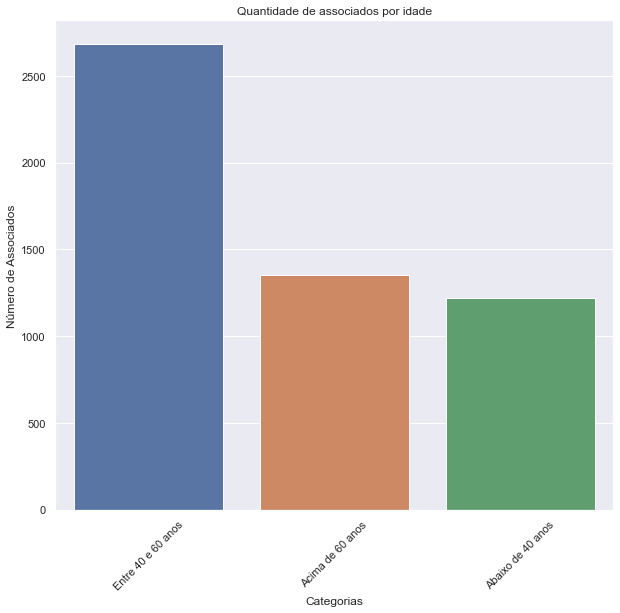

In [34]:
data['idade_control'] = data['Idade'].apply(lambda x: 'Abaixo de 40 anos' if  x< 40 else ( 'Entre 40 e 60 anos') if x < 60 else 'Acima de 60 anos')
idade_control = data['idade_control'].value_counts()
data = data.drop('idade_control', axis=1)


plt.figure(figsize=(10,9))
sns.barplot(x=idade_control.index, y=idade_control.values)
plt.xticks(rotation=45)
plt.xlabel('Categorias')
plt.ylabel('Número de Associados')
plt.title('Quantidade de associados por idade')

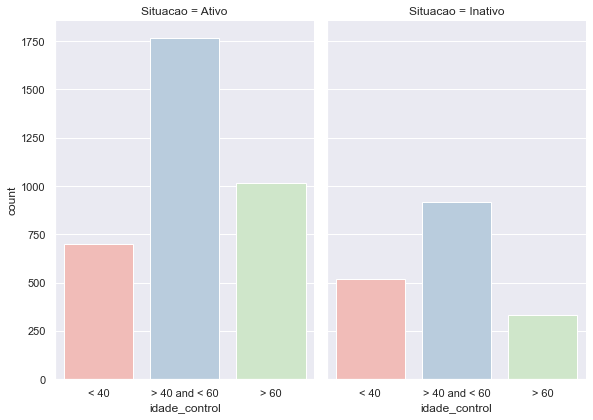

In [35]:
data['idade_control'] = data['Idade'].apply(lambda x: '< 40' if  x< 40 else ( '> 40 and < 60') if x < 60 else '> 60')
df2=data.groupby(['idade_control','Situacao'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

g = sns.catplot(x="idade_control", y="count",col="Situacao",
                data=df2, kind="bar",
                height=6, aspect=.7, palette='Pastel1');
data = data.drop('idade_control', axis=1)

# Visualizações Time de futebol

Text(0.5, 1.0, 'Quantidade de associados que estão em algum time:')

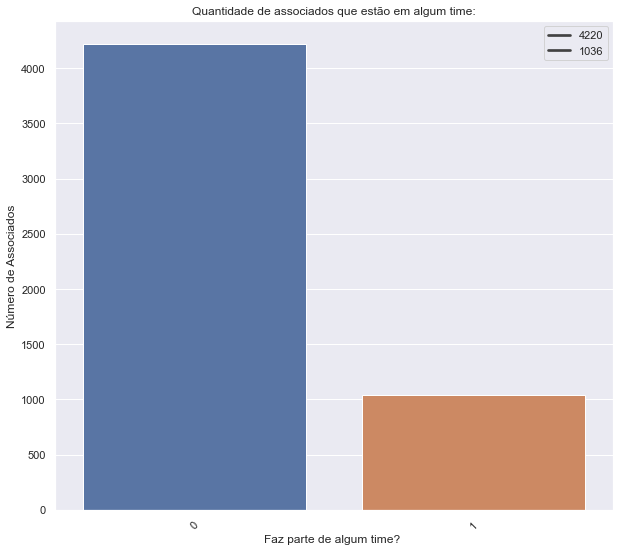

In [36]:
#data['idade_control'] = data['Idade'].apply(lambda x: 'Abaixo de 40 anos' if  x< 40 else ( 'Entre 40 e 60 anos') if x < 60 else 'Acima de 60 anos')
data['Time_control'] = data['Time'].apply(lambda x: 0 if  x== 'Não Participa' else 1)
time_control = data['Time_control'].value_counts()
data = data.drop('Time_control', axis=1)


plt.figure(figsize=(10,9))
sns.barplot(x=time_control.index, y=time_control.values)
plt.xticks(rotation=45)
plt.legend(time_control)
plt.xlabel('Faz parte de algum time? ')
plt.ylabel('Número de Associados')
plt.title('Quantidade de associados que estão em algum time:')

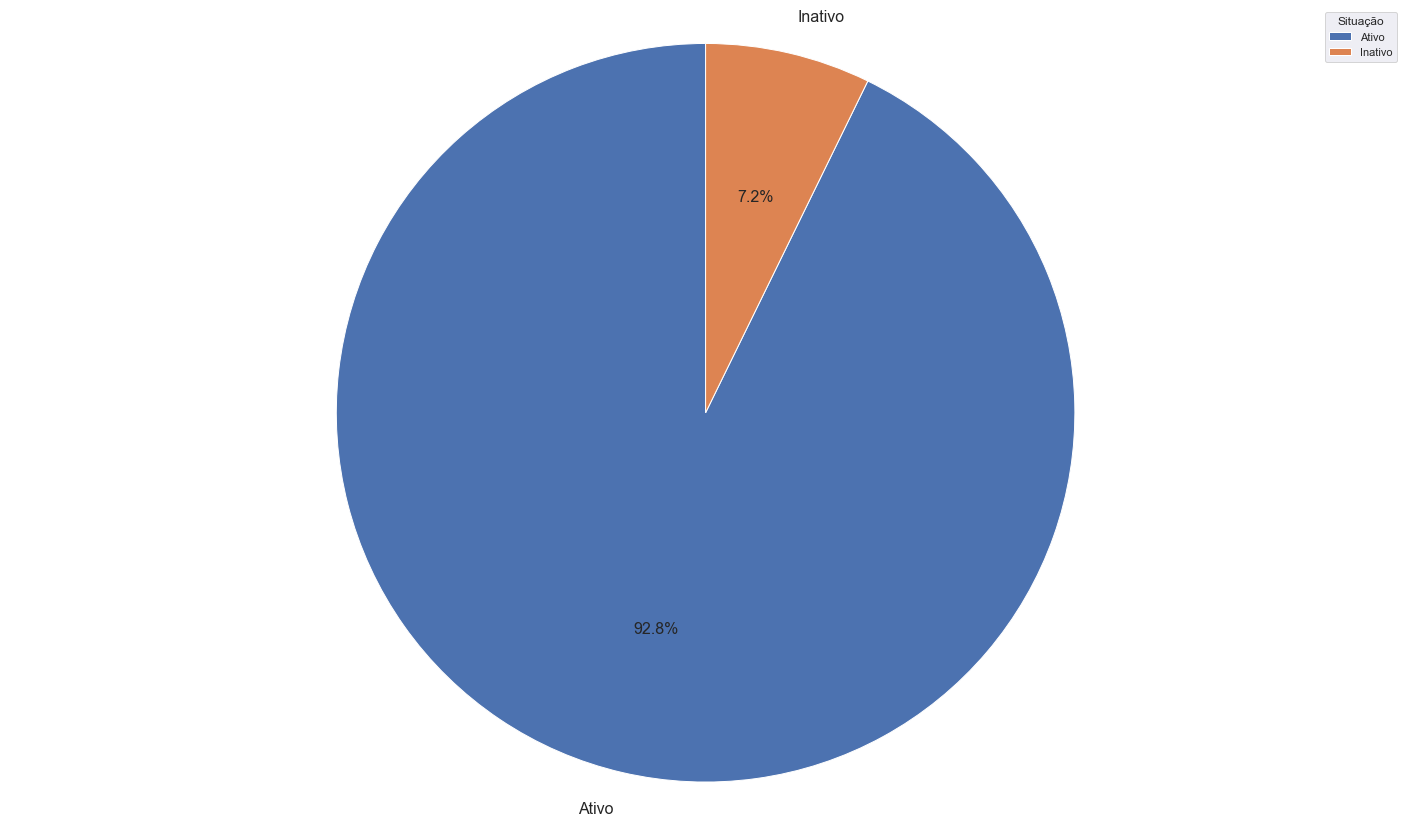

In [37]:
nova_data = data[data['Time'] != 'Não Participa']

time_control = nova_data['Situacao'].value_counts()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = time_control.index
sizes = time_control.values
fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,radius=0.2, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(title='Situação')
plt.show()

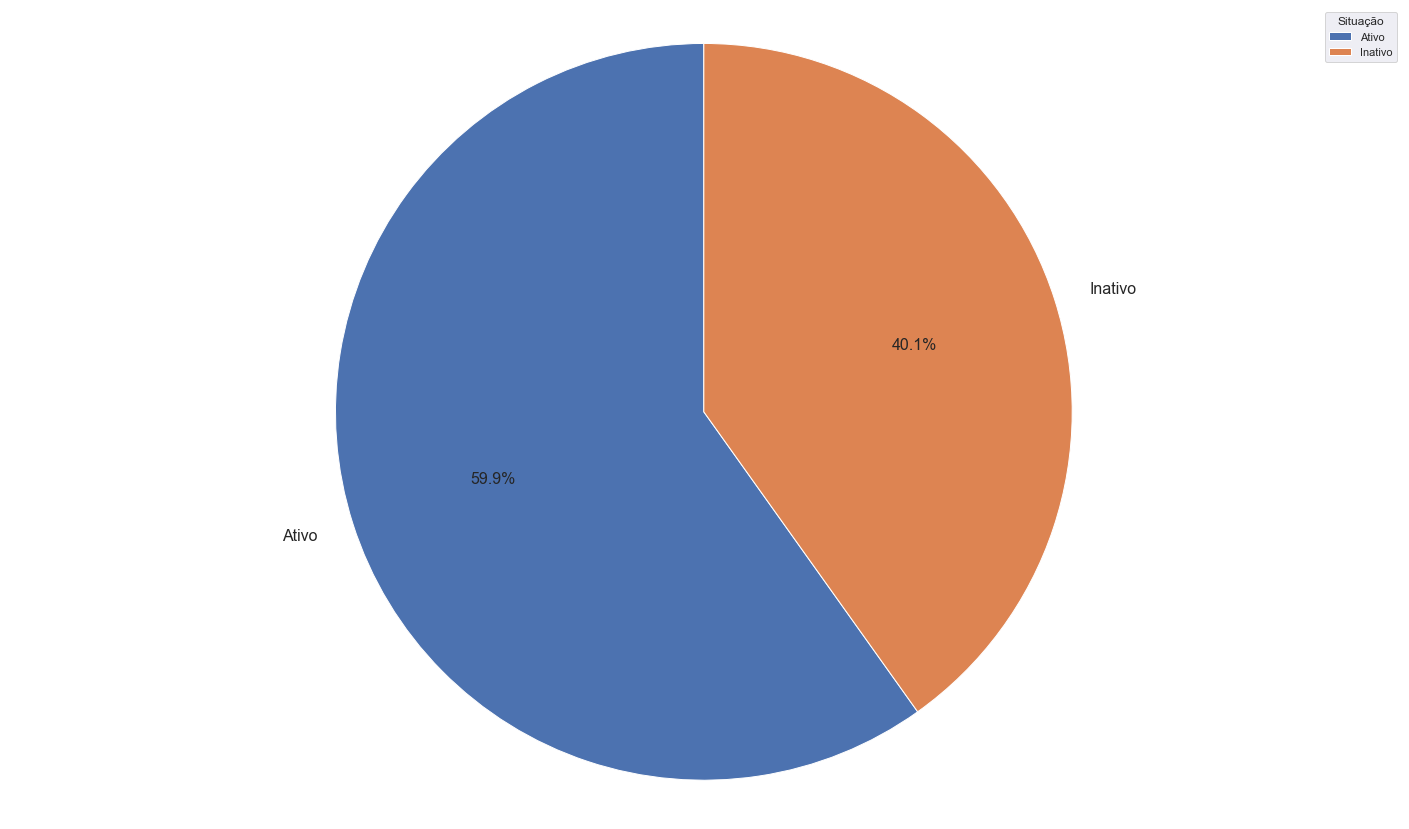

In [38]:
nova_data = data[data['Time'] == 'Não Participa']

time_control = nova_data['Situacao'].value_counts()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = time_control.index
sizes = time_control.values
fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,radius=0.2, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(title='Situação')
plt.show()

# Visualização dos bairros de associados que não participam de campeonato

Text(0.5, 1.0, 'Visualização de associados por Bairro que não participam de campeonato')

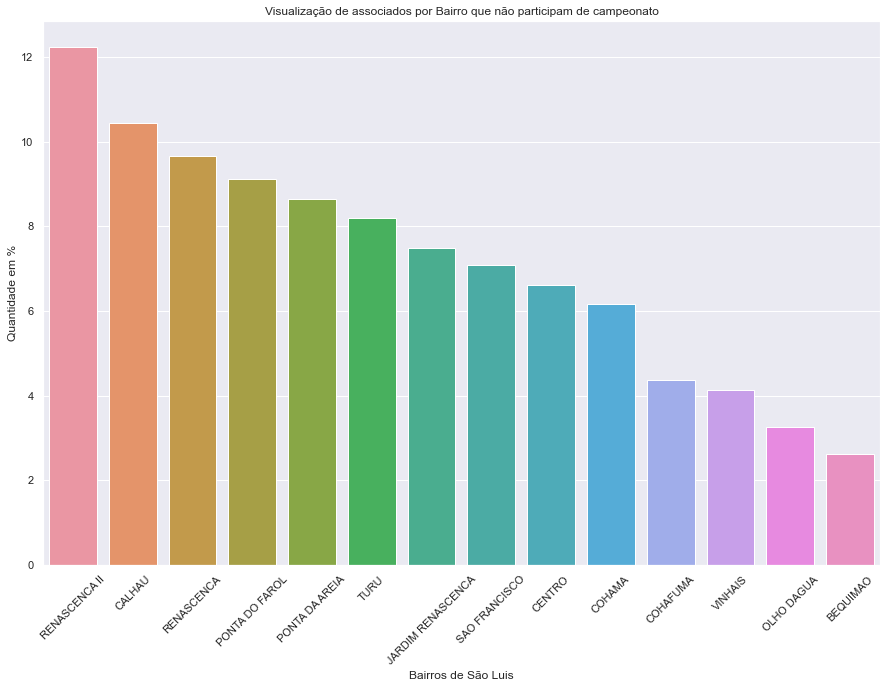

In [39]:
nova_data = data[data['Time'] == 'Não Participa']
data_v = nova_data['Endereço_novo'].value_counts()
data_v_50 = data_v[data_v>50]
total = data_v[data_v>50]
total = total.values.sum()
numero_de_bairros = data_v_50.sort_values(ascending=False)

#Visualização
plt.figure(figsize=(15,10))
sns.barplot(x=numero_de_bairros.index, y=numero_de_bairros.values/total*100)
plt.xticks(rotation= 45)
plt.xlabel('Bairros de São Luis')
plt.ylabel('Quantidade em %')
plt.title('Visualização de associados por Bairro que não participam de campeonato')

# Visualização dos bairros de associados que participam de campeonato

Text(0.5, 1.0, 'Visualização de clientes por Bairro')

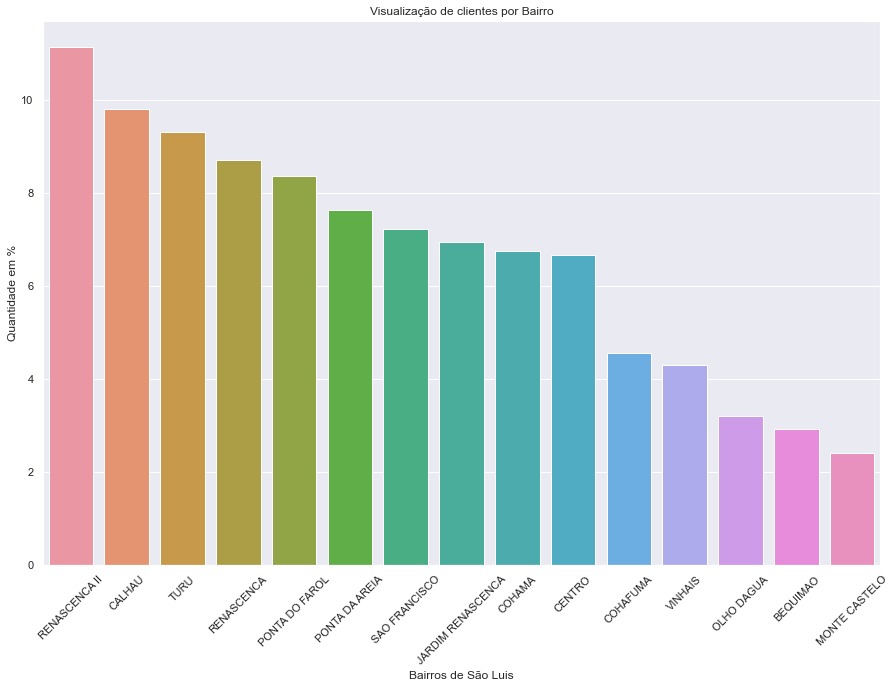

In [40]:
nova_data = data[data['Time'] != 'Não participa']
data_v = nova_data['Endereço_novo'].value_counts()
data_v_50 = data_v[data_v>50]
total = data_v[data_v>50]
total = total.values.sum()
numero_de_bairros = data_v_50.sort_values(ascending=False)

#Visualização
plt.figure(figsize=(15,10))
sns.barplot(x=numero_de_bairros.index, y=numero_de_bairros.values/total*100)
plt.xticks(rotation= 45)
plt.xlabel('Bairros de São Luis')
plt.ylabel('Quantidade em %')
plt.title('Visualização de clientes por Bairro')

Text(0.5, 1.0, 'Quantidade de associados participante de campeonatos por idade')

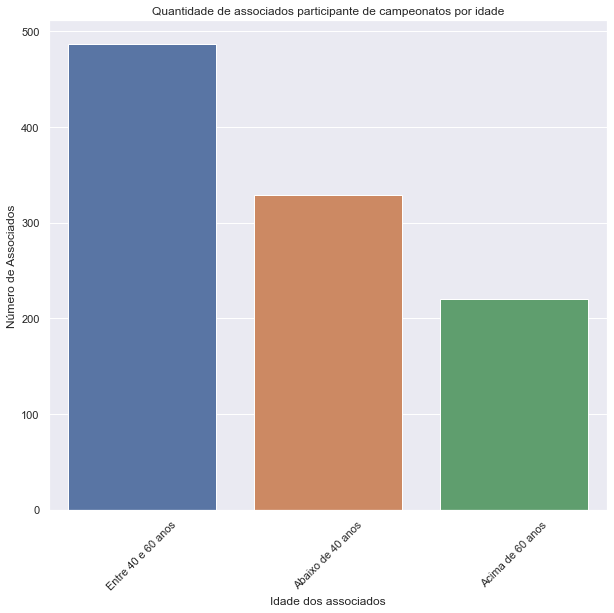

In [41]:
nova_data.reset_index(inplace=True)
data['idade_control'] = data['Idade'].apply(lambda x: 'Abaixo de 40 anos' if  x< 40 else ( 'Entre 40 e 60 anos') if x < 60 else 'Acima de 60 anos')
nova_data = data[data['Time'] != 'Não Participa']
idade_control = nova_data['idade_control'].value_counts()
data = data.drop('idade_control', axis=1)


plt.figure(figsize=(10,9))
sns.barplot(x=idade_control.index, y=idade_control.values)
plt.xticks(rotation=45)
plt.xlabel('Idade dos associados')
plt.ylabel('Número de Associados')
plt.title('Quantidade de associados participante de campeonatos por idade')

Text(0.5, 1.0, 'Quantidade de associados não participante de campeonatos por idade')

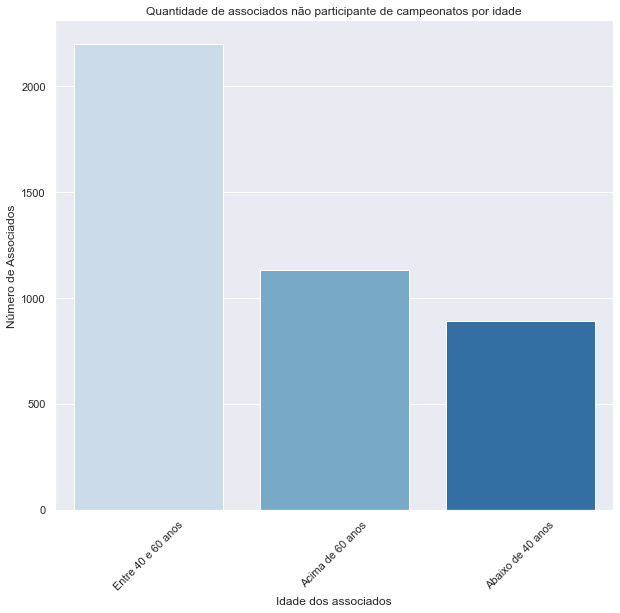

In [42]:
data['idade_control'] = data['Idade'].apply(lambda x: 'Abaixo de 40 anos' if  x< 40 else ( 'Entre 40 e 60 anos') if x < 60 else 'Acima de 60 anos')
nova_data = data[data['Time'] == 'Não Participa']
idade_control = nova_data['idade_control'].value_counts()
data = data.drop('idade_control', axis=1)


plt.figure(figsize=(10,9))
sns.barplot(x=idade_control.index, y=idade_control.values, palette='Blues')
plt.xticks(rotation=45)
plt.xlabel('Idade dos associados')
plt.ylabel('Número de Associados')
plt.title('Quantidade de associados não participante de campeonatos por idade')

Text(0, 0.5, 'Quantidade')

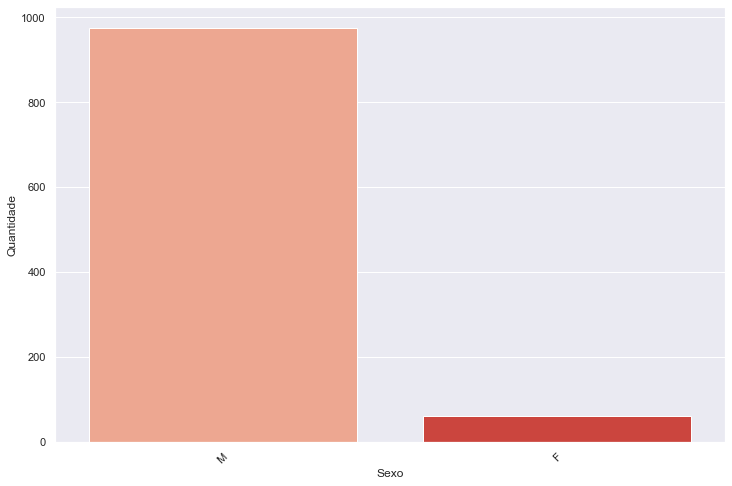

In [46]:
nova_data = data[data['Time'] != 'Não Participa']
data_prov = nova_data['Sexo'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(12,8))
sns.barplot(x=data_prov.index, y=data_prov.values,  palette='Reds')
plt.xticks(rotation=45)
plt.xlabel('Sexo')
plt.ylabel('Quantidade')

Text(0, 0.5, 'Quantidade')

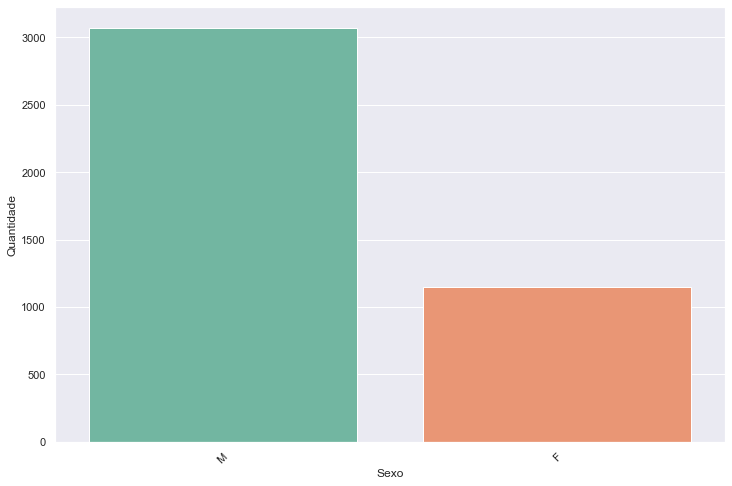

In [44]:
nova_data = data[data['Time'] == 'Não Participa']
data_prov = nova_data['Sexo'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(12,8))
sns.barplot(x=data_prov.index, y=data_prov.values, palette=sns.color_palette("Set2"))
plt.xticks(rotation=45)
plt.xlabel('Sexo')
plt.ylabel('Quantidade')

# Conclusões

## Perfil do associado geral

- Predominância do sexo masculino
- O sexo parece não influenciar na situação do associado (Ativo ou inativo)
- A maior parte dos associados se encontram em bairros próximos à AABB
- Bairros mais distantes tendem a possuir maior índice de associados inativos
- 94.5% dos associados não estão utilizando dos serviços de escolinhas
- Natação é o esporte mais utilizado por associados na escolinha - 46,5%
- A faixa etária predomimante dos associados está entre 40 e 60 anos
    - Associados acima de 60 anos tendem a sobressair como Ativos
    - Enquanto associados abaixo de 40 anos possuem a maior taxa de inativos

## Comparação entre associados que participam de algum time e aqueles que não participam

- Associados que participam de algum time:
    - Sexo Masculino;
    - Presença acentuada de bairros mais distantes;
    - Presença notável de associados com menos de 50 anos.
    </br>


- Associados que não participam:
    - Predominância do sexo masculino;
    - Tendência de associados morarem em bairros mais próximos à AABB
    - Presença notável de associados acima de 50 anos.